### Requirment : predict whether income of an individual exceeds 50K/per year based on census data

### Given : 
####              Link:http://archive.ics.uci.edu/ml/datasets/Adult


### IMPORTING ALL THE REQUIRED LIBRARIES:

In [1]:
# !pip install category_encoders
import urllib
from urllib.request import urlopen
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.pipeline import Pipeline, FeatureUnion,make_pipeline
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.preprocessing import FunctionTransformer, StandardScaler,MinMaxScaler,   OrdinalEncoder, OneHotEncoder
from category_encoders import TargetEncoder,LeaveOneOutEncoder, WOEEncoder
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split,cross_val_score,StratifiedKFold,cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
import pickle

### CHECKING THE CONTENT PRESENT IN GIVEN URL : 

In [2]:
link = "http://archive.ics.uci.edu/ml/machine-learning-databases/adult/"
f = urlopen(link)
myfile = f.read()
print(myfile.decode('UTF-8'))

<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 3.2 Final//EN">
<html>
 <head>
  <title>Index of /ml/machine-learning-databases/adult</title>
 </head>
 <body>
<h1>Index of /ml/machine-learning-databases/adult</h1>
<ul><li><a href="/ml/machine-learning-databases/"> Parent Directory</a></li>
<li><a href="Index"> Index</a></li>
<li><a href="adult.data"> adult.data</a></li>
<li><a href="adult.names"> adult.names</a></li>
<li><a href="adult.test"> adult.test</a></li>
<li><a href="old.adult.names"> old.adult.names</a></li>
</ul>
<address>Apache/2.4.6 (CentOS) OpenSSL/1.0.2k-fips SVN/1.7.14 Phusion_Passenger/4.0.53 mod_perl/2.0.11 Perl/v5.16.3 Server at archive.ics.uci.edu Port 80</address>
</body></html>



In [3]:
##### Seems like content have 4 data items, and importantly, data, test , names. 
#adult.data
#adult.names
#adult.test


### Getting the content of data, test 

In [145]:
link_data = "http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
df_data=pd.read_csv(link_data)
print(" data have : " ,df_data.shape)
print(df_data.head())
link_test = "http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"
df_test=pd.read_csv(link_test,skiprows=1)
print(" test have : ",df_test.shape)
print(df_test.head())

 data have :  (32560, 15)
   39          State-gov   77516   Bachelors   13        Never-married  \
0  50   Self-emp-not-inc   83311   Bachelors   13   Married-civ-spouse   
1  38            Private  215646     HS-grad    9             Divorced   
2  53            Private  234721        11th    7   Married-civ-spouse   
3  28            Private  338409   Bachelors   13   Married-civ-spouse   
4  37            Private  284582     Masters   14   Married-civ-spouse   

         Adm-clerical   Not-in-family   White     Male   2174   0   40  \
0     Exec-managerial         Husband   White     Male      0   0   13   
1   Handlers-cleaners   Not-in-family   White     Male      0   0   40   
2   Handlers-cleaners         Husband   Black     Male      0   0   40   
3      Prof-specialty            Wife   Black   Female      0   0   40   
4     Exec-managerial            Wife   White   Female      0   0   40   

    United-States   <=50K  
0   United-States   <=50K  
1   United-States   <=50K  


### Train and test data is received , and now to get column names ' Names'

In [146]:
link_names = "http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names"
names=urllib.request.urlopen(link_names).read()
columns=re.findall(r'\n[a-zA-Z-]+:',names.decode('utf-8'))
columns=[x[1:-1] for x in columns]
columns

['age',
 'workclass',
 'fnlwgt',
 'education',
 'education-num',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'capital-gain',
 'capital-loss',
 'hours-per-week',
 'native-country']

In [147]:
# since we have column names only 14 and in data we have 15 columns, i am taking target as 15th columns 
columns.append('target')

### Reading dataset with required format : 

In [148]:
# reading training dataset : 

df_data=pd.read_csv(link_data,names=columns)
df_data.head()


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [149]:
# reading testing dataset : 

df_test=pd.read_csv(link_test,skiprows=1,names=columns)
df_test.head()


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.


### Now the dataset is ready, Understanding the dataset :


### Descriptive Statistics : 

In [9]:
#Now that we have train, test datasets, i am using train dataset, to understand the data

In [10]:
#Listing valuecounts to see what exactly that each column contains :


In [11]:
for i in df_data.columns:
    print('#########################################################################################################')
    print('printing the value counts of '+i)
    print(df_data[i].value_counts())

#########################################################################################################
printing the value counts of age
36    898
31    888
34    886
23    877
35    876
     ... 
83      6
85      3
88      3
86      1
87      1
Name: age, Length: 73, dtype: int64
#########################################################################################################
printing the value counts of workclass
 Private             22696
 Self-emp-not-inc     2541
 Local-gov            2093
 ?                    1836
 State-gov            1298
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: workclass, dtype: int64
#########################################################################################################
printing the value counts of fnlwgt
203488    13
123011    13
164190    13
148995    12
113364    12
          ..
218551     1
201204     1
362999     1
162297     1
145522     1
Name: fnlwgt

In [12]:
#Descriptive Statisctics :

df_data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,32561.0,NaN,NaN,NaN,38.581647,13.640433,17.0,28.0,37.0,48.0,90.0
workclass,32561,9,Private,22696,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fnlwgt,32561.0,NaN,NaN,NaN,189778.366512,105549.977697,12285.0,117827.0,178356.0,237051.0,1484705.0
education,32561,16,HS-grad,10501,NaN,NaN,NaN,NaN,NaN,NaN,NaN
education-num,32561.0,NaN,NaN,NaN,10.080679,2.57272,1.0,9.0,10.0,12.0,16.0
marital-status,32561,7,Married-civ-spouse,14976,NaN,NaN,NaN,NaN,NaN,NaN,NaN
occupation,32561,15,Prof-specialty,4140,NaN,NaN,NaN,NaN,NaN,NaN,NaN
relationship,32561,6,Husband,13193,NaN,NaN,NaN,NaN,NaN,NaN,NaN
race,32561,5,White,27816,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sex,32561,2,Male,21790,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
df_data.skew() # diff of mean and median

age                0.558743
fnlwgt             1.446980
education-num     -0.311676
capital-gain      11.953848
capital-loss       4.594629
hours-per-week     0.227643
dtype: float64

In [14]:
df_data.kurtosis() #deviation of height

age                -0.166127
fnlwgt              6.218811
education-num       0.623444
capital-gain      154.799438
capital-loss       20.376802
hours-per-week      2.916687
dtype: float64

In [15]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  target          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [16]:
cat_columns=['workclass','education','marital-status','occupation','relationship','race','sex','native-country']
num_columns=['age','fnlwgt','education-num','capital-gain','capital-loss','hours-per-week']

In [17]:
#data set having chance of outliers data

### Missing Values  :

In [18]:
for i in df_data.columns:
    print('#########################################################################################################')
    print('printing the Missing values of '+i)
    print(df_data[i].isnull().sum()) 

#########################################################################################################
printing the Missing values of age
0
#########################################################################################################
printing the Missing values of workclass
0
#########################################################################################################
printing the Missing values of fnlwgt
0
#########################################################################################################
printing the Missing values of education
0
#########################################################################################################
printing the Missing values of education-num
0
#########################################################################################################
printing the Missing values of marital-status
0
#########################################################################################################


### Anamoly :

In [19]:
for i in cat_columns:
    print('#########################################################################################################')
    print('printing the value counts of '+i)
    print(df_data[i].value_counts())

#########################################################################################################
printing the value counts of workclass
 Private             22696
 Self-emp-not-inc     2541
 Local-gov            2093
 ?                    1836
 State-gov            1298
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: workclass, dtype: int64
#########################################################################################################
printing the value counts of education
 HS-grad         10501
 Some-college     7291
 Bachelors        5355
 Masters          1723
 Assoc-voc        1382
 11th             1175
 Assoc-acdm       1067
 10th              933
 7th-8th           646
 Prof-school       576
 9th               514
 12th              433
 Doctorate         413
 5th-6th           333
 1st-4th           168
 Preschool          51
Name: education, dtype: int64
#######################################

In [20]:
#trimming the space :
df_data[cat_columns]=df_data[cat_columns].applymap(lambda x : x.strip())

In [21]:
#Checking the missing values:
#Checcking appereance of '?' is at same time or not :
df_data[cat_columns]=df_data[cat_columns].replace('?',np.NaN)

Text(0.5, 1.0, 'Missing Values')

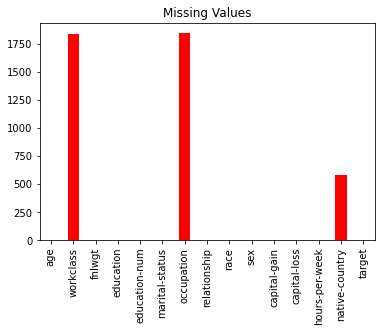

In [22]:
df_data.isnull().sum().plot(kind='bar',color='r')
plt.title('Missing Values')

<AxesSubplot:>

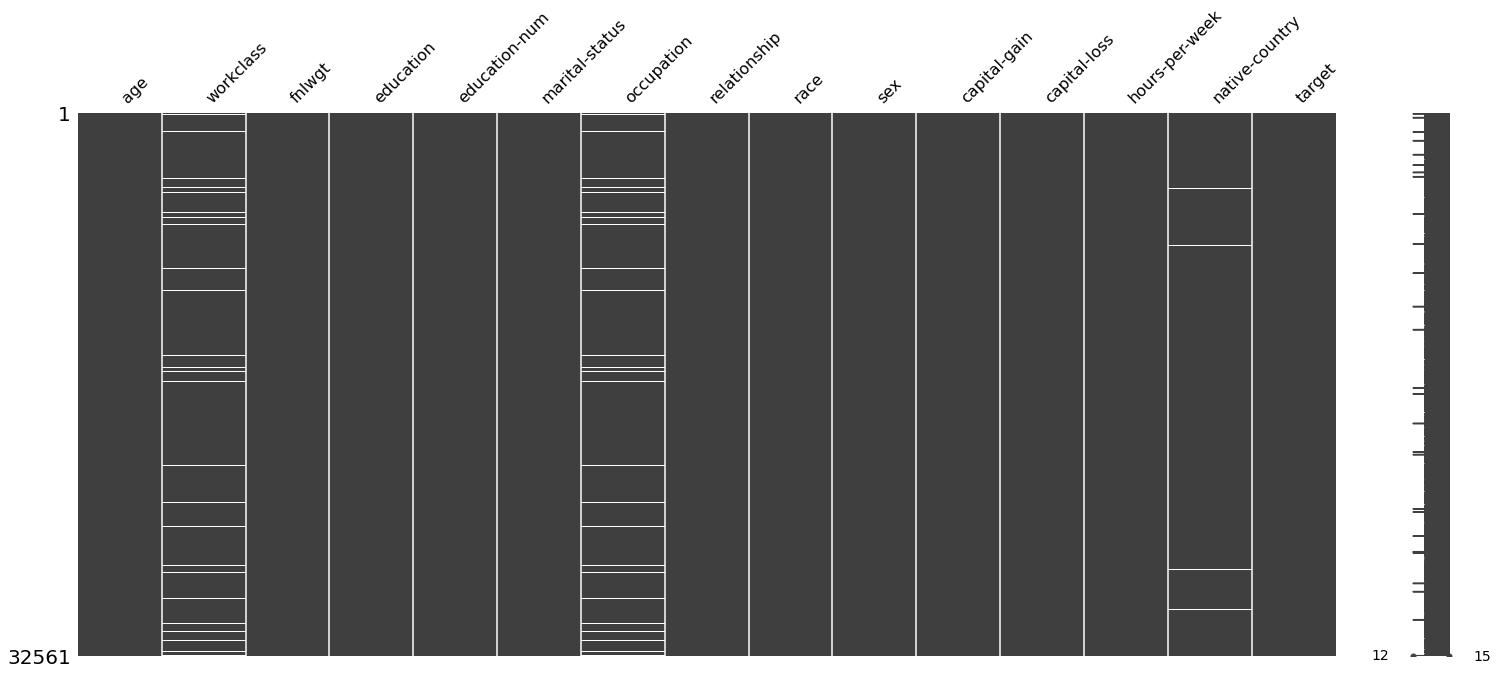

In [23]:
#checking the relation between missing values :
import missingno as msno
msno.matrix(df_data)

In [24]:
#Looks like 'workclass','occupation ' are missing at same time :
#   that means people who likely to keep workclass empty are likely to keep occupation empty , so before proceeding futher 
##  i can check whether these people salary is less than 50 or more than 50 

salary of people whose workclass or occupation kept ? :
  <=50K    1652
 >50K      191
Name: target, dtype: int64


<AxesSubplot:xlabel='target', ylabel='count'>

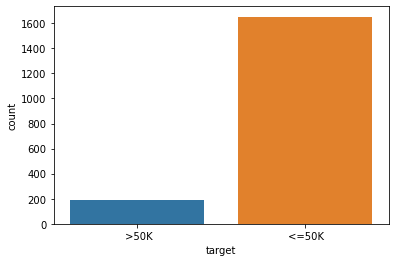

In [25]:
print('salary of people whose workclass or occupation kept ? :\n', df_data.loc[df_data['workclass'].isnull() | df_data['occupation'].isnull()].target.value_counts())
sns.countplot('target',data=df_data.loc[df_data['workclass'].isnull() | df_data['occupation'].isnull()])

### Univariate - Analysis :

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'fnlwgt'}>],
       [<AxesSubplot:title={'center':'education-num'}>,
        <AxesSubplot:title={'center':'capital-gain'}>],
       [<AxesSubplot:title={'center':'capital-loss'}>,
        <AxesSubplot:title={'center':'hours-per-week'}>]], dtype=object)

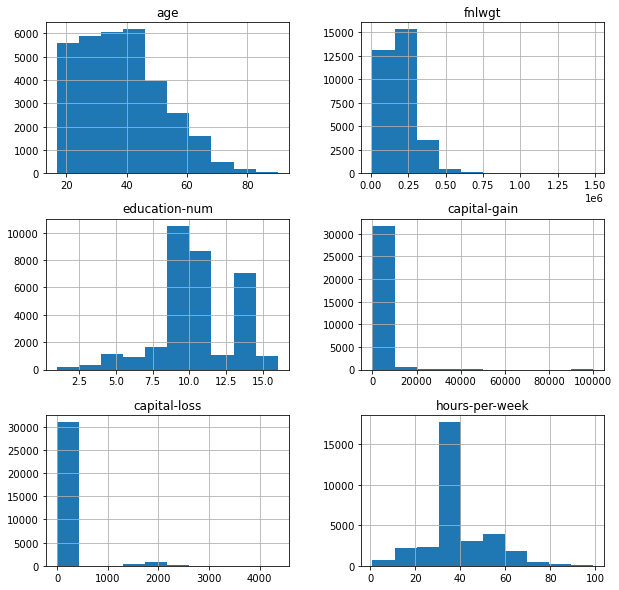

In [26]:
#
df_data.hist(figsize=(10,10))

<AxesSubplot:>

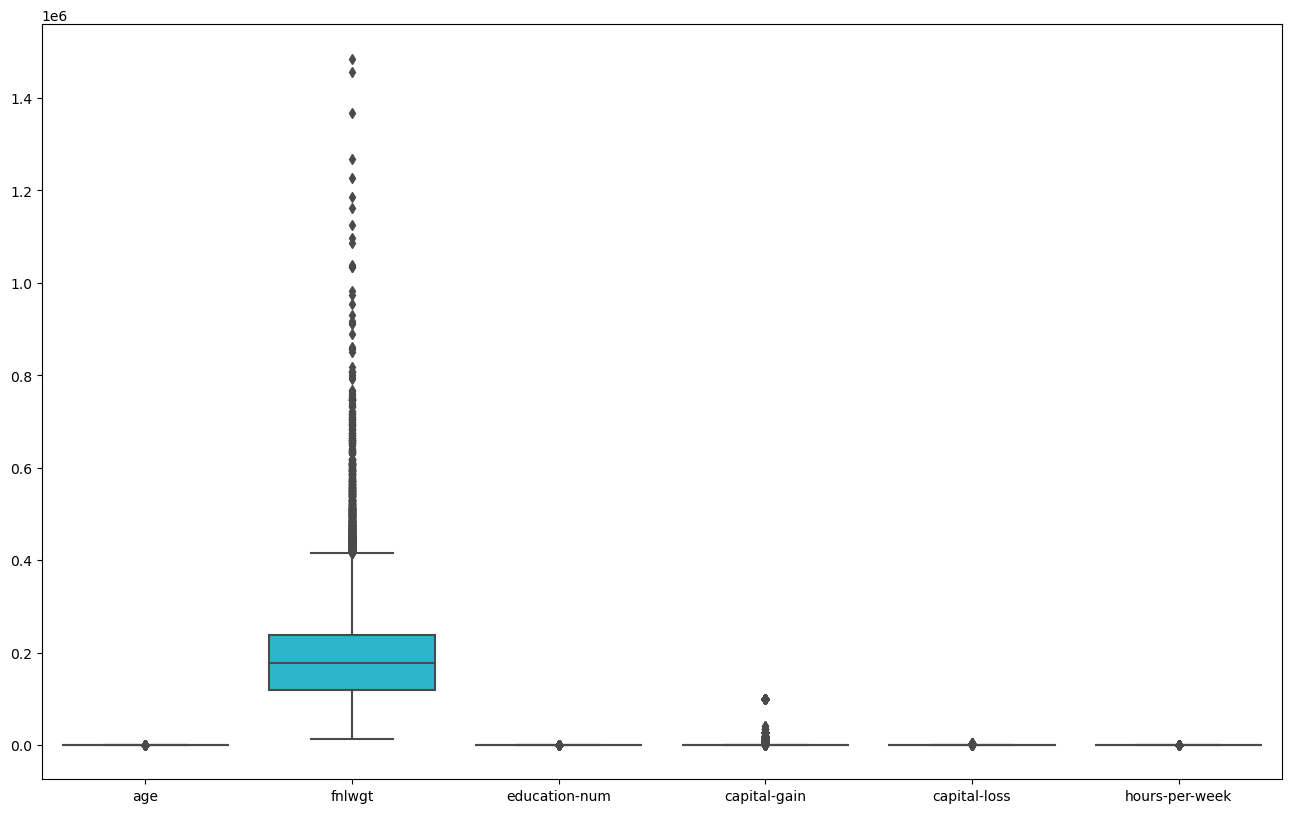

In [27]:
plt.figure(dpi=100,figsize=(16,10))
sns.boxplot(data=df_data,palette='rainbow')

<AxesSubplot:>

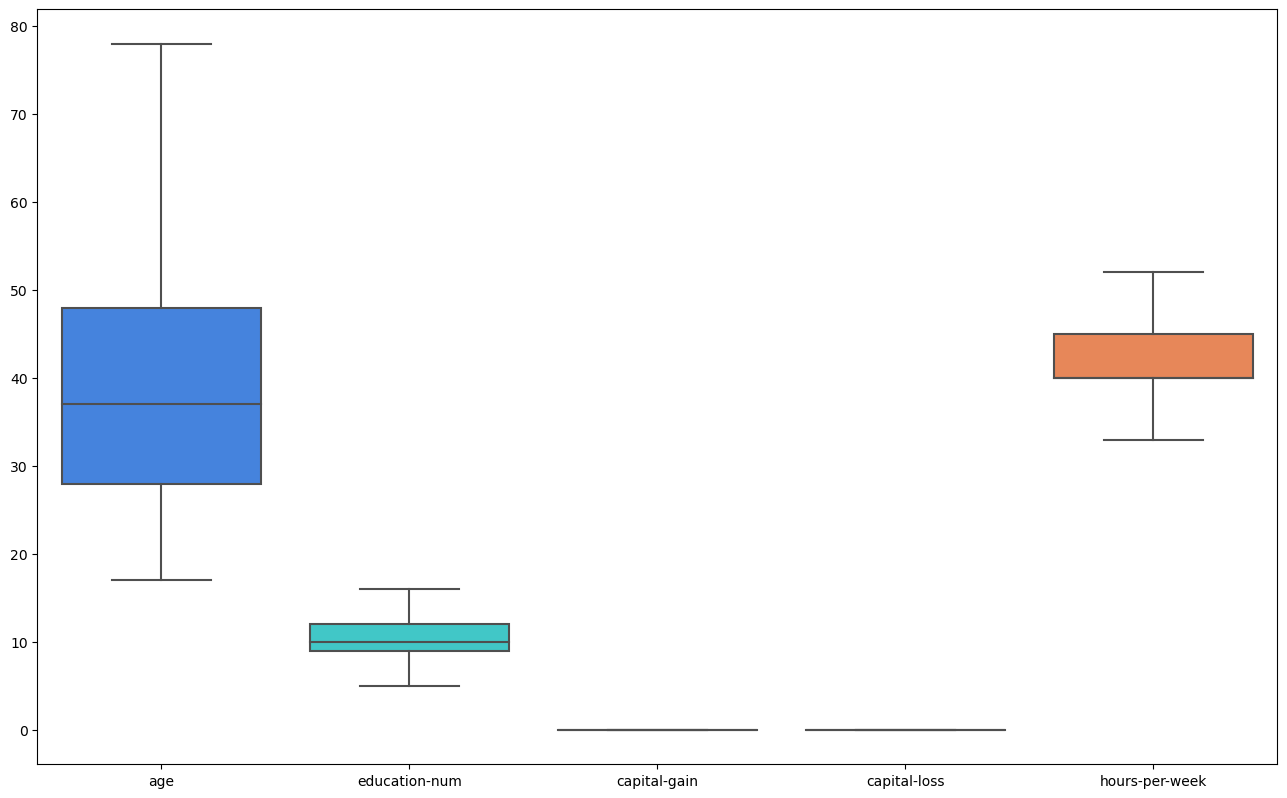

In [28]:
plt.figure(dpi=100,figsize=(16,10))
sns.boxplot(data=df_data.drop(['target','fnlwgt'],axis=1),palette='rainbow',showfliers=False)

----------------------------------------------age------------------------------------------------------


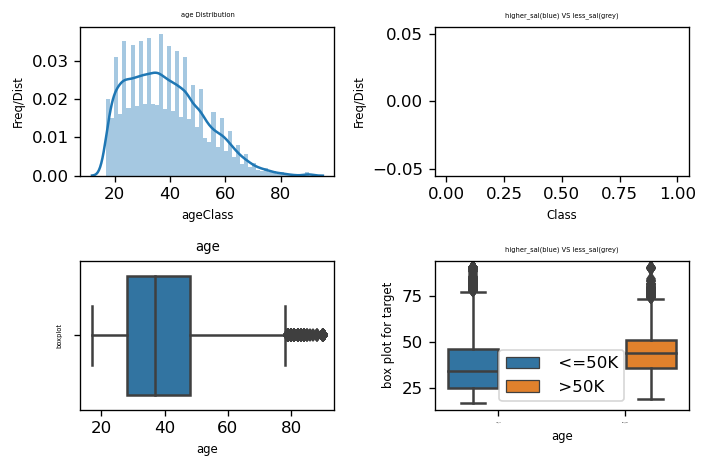

----------------------------------------------fnlwgt------------------------------------------------------


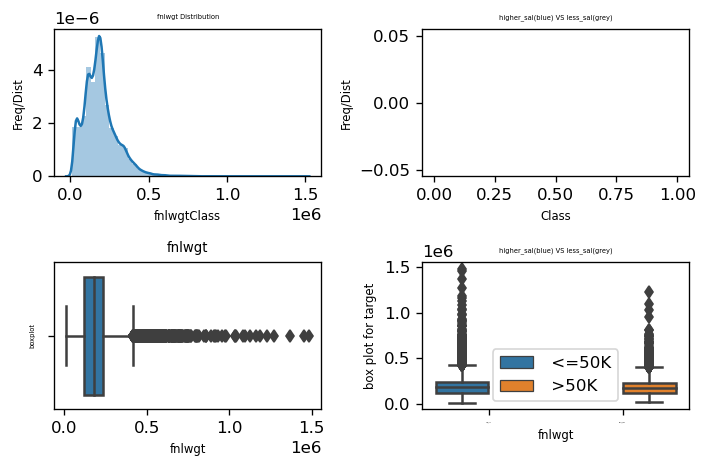

----------------------------------------------education-num------------------------------------------------------


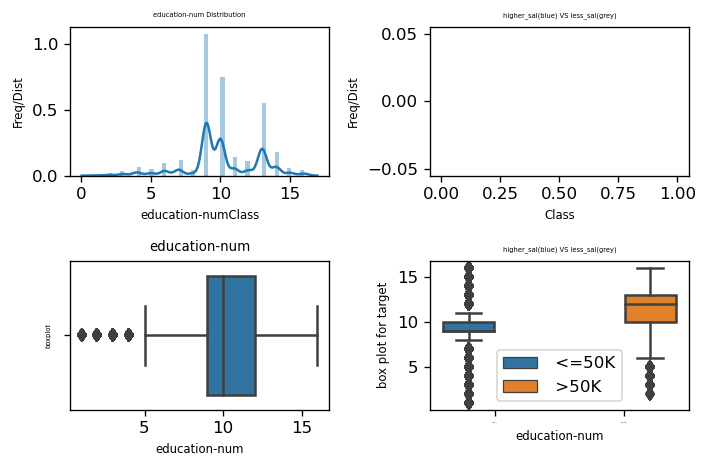

----------------------------------------------capital-gain------------------------------------------------------


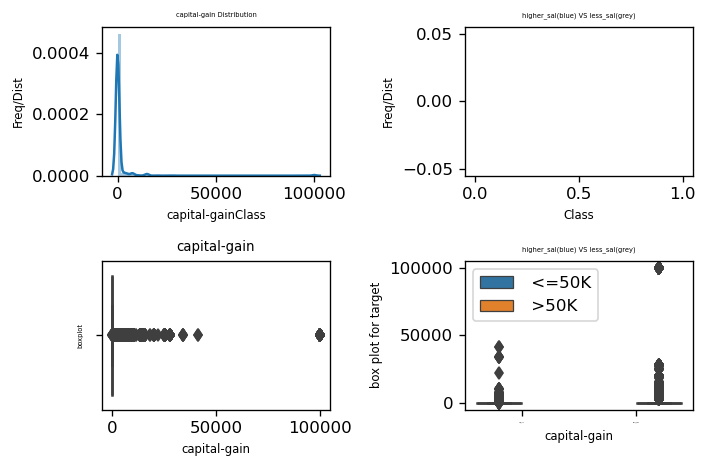

----------------------------------------------capital-loss------------------------------------------------------


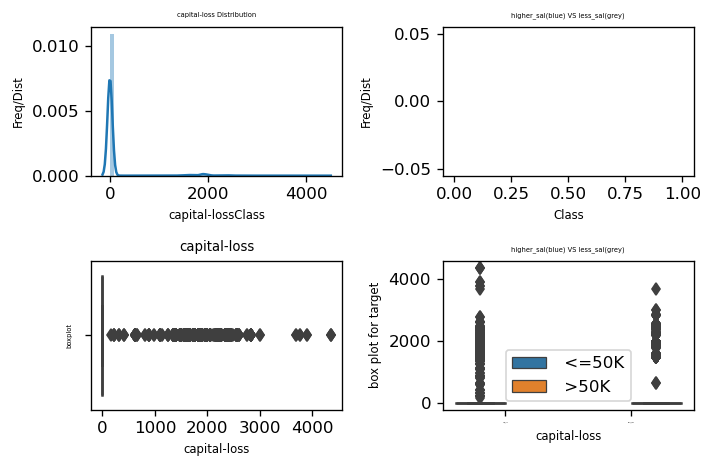

----------------------------------------------hours-per-week------------------------------------------------------


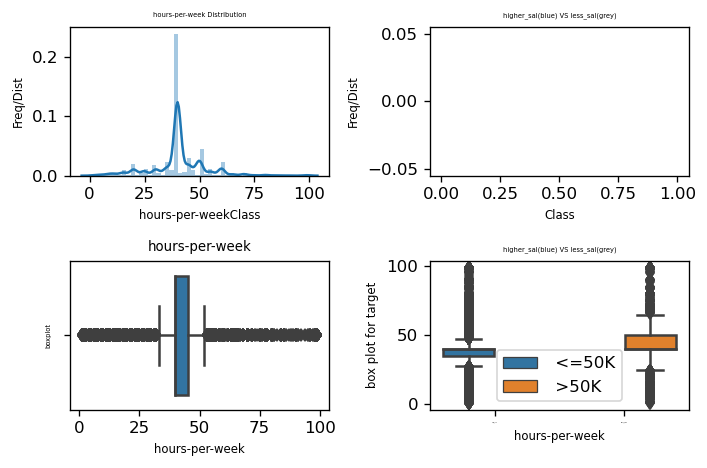

In [29]:
#for checking univariate analysis:
def univariate_analyis(df,col):
    print('----------------------------------------------'+col+'------------------------------------------------------')
    fig,axes = plt.subplots(nrows=2,ncols=2,dpi=120,figsize = (6,4))
    sns.distplot(df[col],ax=axes[0][0])
    axes[0][0].set_title(col+' Distribution',fontdict={'fontsize':4})
    axes[0][0].set_xlabel(col+'Class',fontdict={'fontsize':7})
    axes[0][0].set_ylabel('Freq/Dist',fontdict={'fontsize':7})
    plt.tight_layout()

    sns.distplot(df[df.target==0][col],kde=False,color="grey", label="Outcome=0", ax=axes[0][1])
    sns.distplot(df.loc[df.target==1][col],kde=False, color="blue", label="Outcome=1", ax=axes[0][1])
    axes[0][1].set_title('higher_sal(blue) VS less_sal(grey)',fontdict={'fontsize':4})
    axes[0][1].set_xlabel('Class',fontdict={'fontsize':7})
    axes[0][1].set_ylabel('Freq/Dist',fontdict={'fontsize':7})
    lines, labels = axes[0][1].get_legend_handles_labels()
    plt.legend(lines,labels,loc='best')
    plt.tight_layout()

    sns.boxplot(df[col],ax=axes[1][0],orient='v')
    axes[1][0].set_title(col,fontdict={'fontsize':8})
    axes[1][0].set_xlabel(col,fontdict={'fontsize':7})
    axes[1][0].set_ylabel('boxplot',fontdict={'fontsize':4})
    plt.tight_layout()

    sns.boxplot(x='target',y=col,data=df,ax=axes[1][1],hue=df.target)
    axes[1][1].set_title('higher_sal(blue) VS less_sal(grey)',fontdict={'fontsize':4})
    axes[1][1].set_xlabel(col,fontdict={'fontsize':7})
    axes[1][1].set_ylabel('box plot for target',fontdict={'fontsize':7})
    plt.xticks(ticks=[0,1],labels=['low_sal','high_sal'],fontsize=1)
    lines, labels = axes[1][1].get_legend_handles_labels()
    plt.legend(lines,labels,loc='best')
    plt.tight_layout()
    plt.show()
    

for i in num_columns:
    univariate_analyis(df_data,i)

In [30]:
target_bal = df_data['target'].value_counts(normalize = True).rename_axis('target').reset_index(name = '% of people')
target_bal

,target,% of people
0,<=50K,0.75919
1,>50K,0.24081


                              ##################             WORKCLASS         ####################


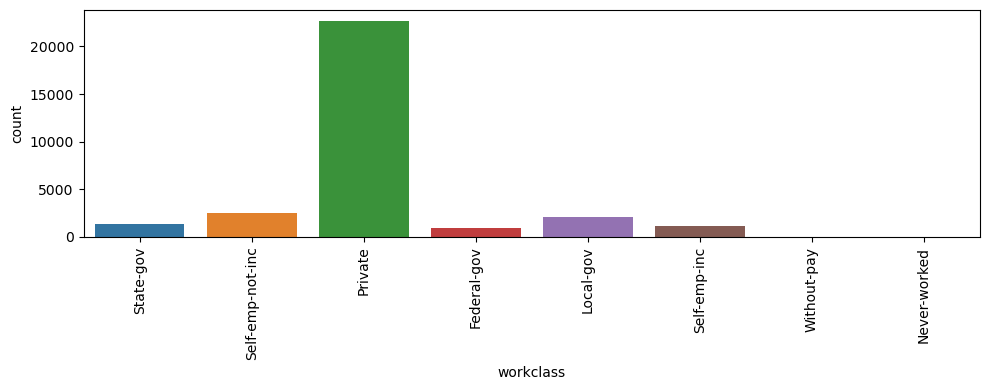

                              ##################             EDUCATION         ####################


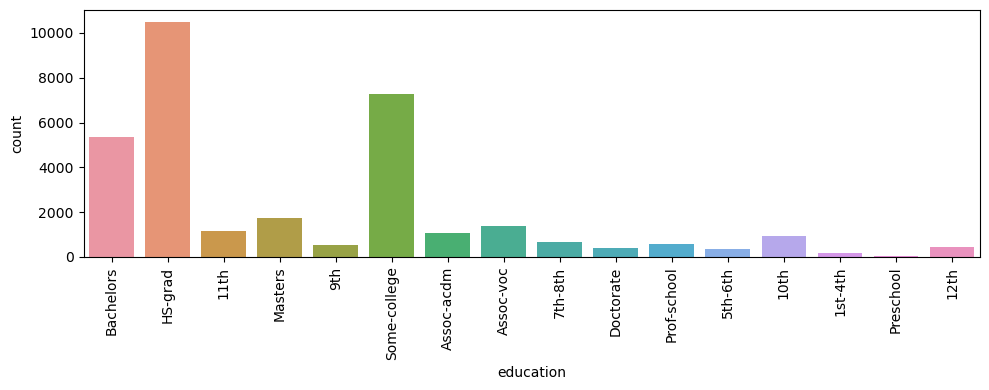

                              ##################             MARITAL-STATUS         ####################


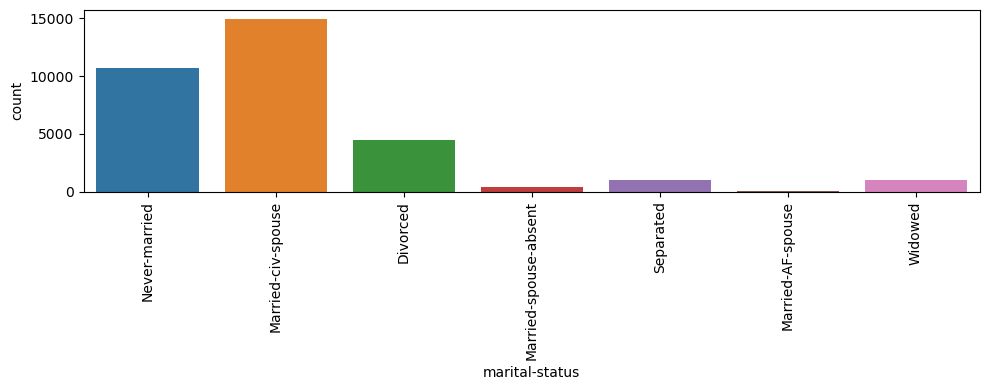

                              ##################             OCCUPATION         ####################


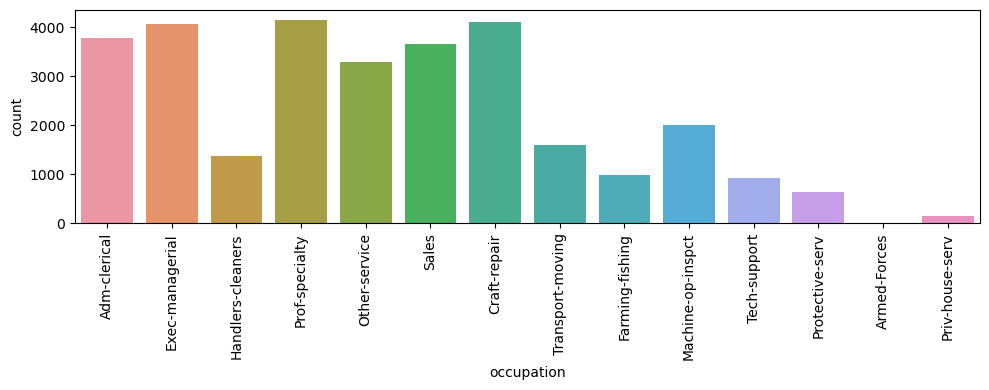

                              ##################             RELATIONSHIP         ####################


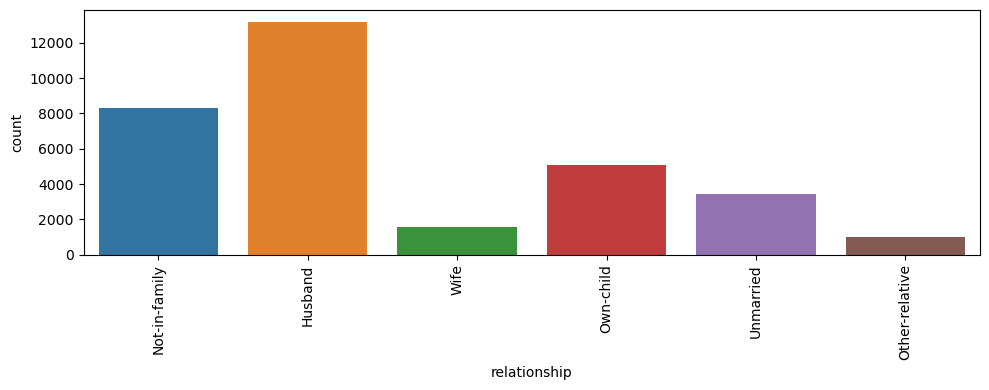

                              ##################             RACE         ####################


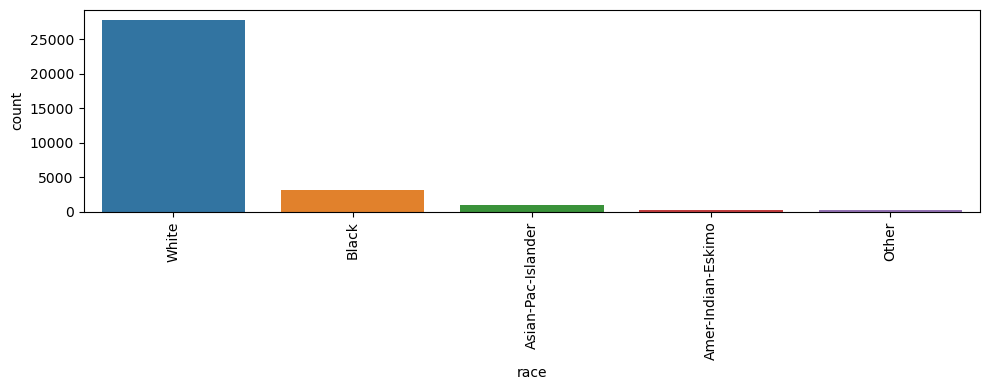

                              ##################             SEX         ####################


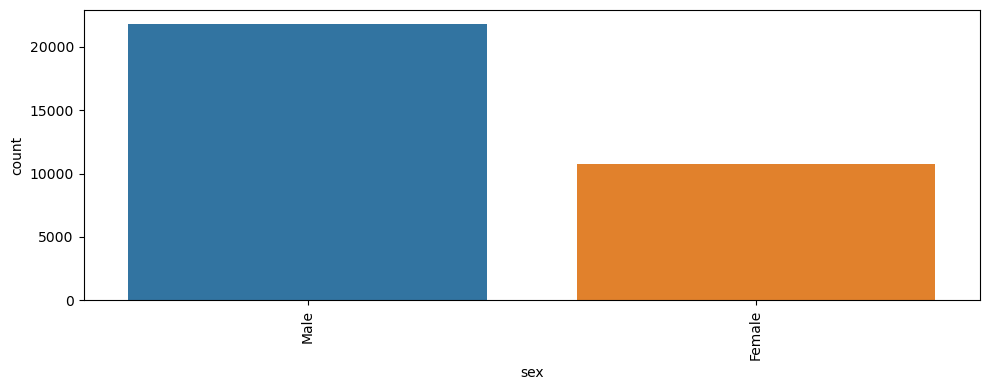

                              ##################             NATIVE-COUNTRY         ####################


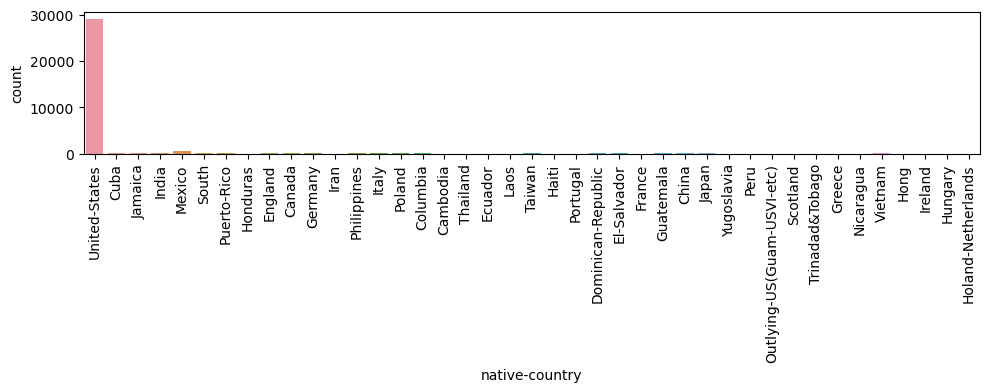

In [31]:
def cat_univariate(df_data,i):
    fig,ax = plt.subplots(nrows=1,ncols=1,dpi=100,figsize=(10,4))
    sns.countplot(x=df_data[i],ax=ax,orient=False)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
for i in cat_columns:
    print('                              ##################             '+ i.upper() +'         ####################')
    cat_univariate(df_data,i)
    

   

### BI VARIATE AND MULTIVARIATE :


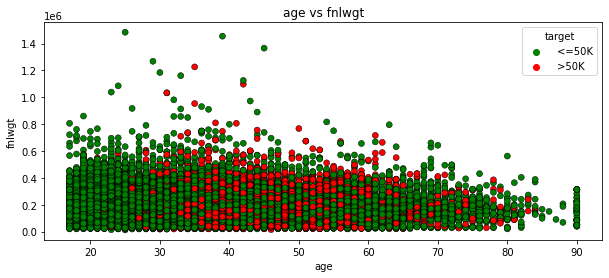

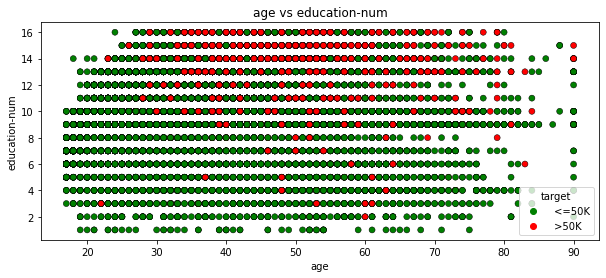

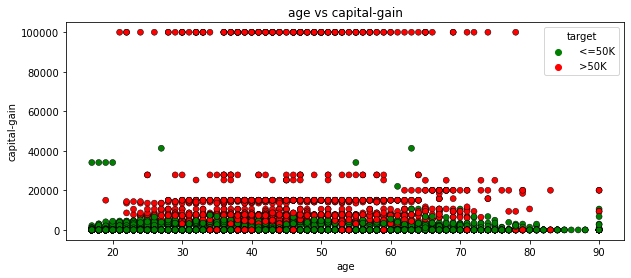

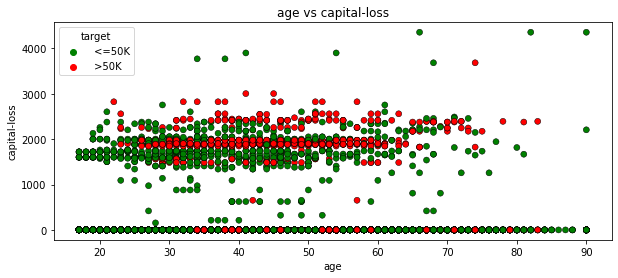

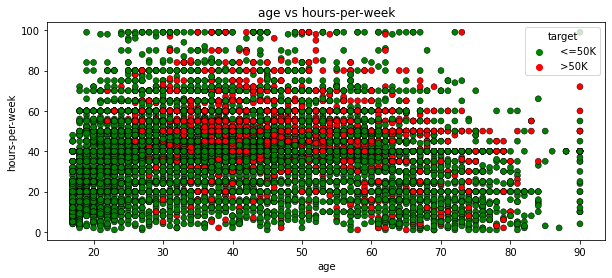

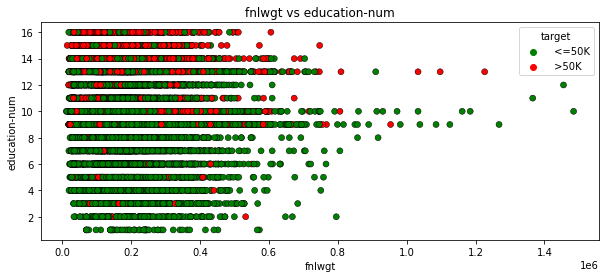

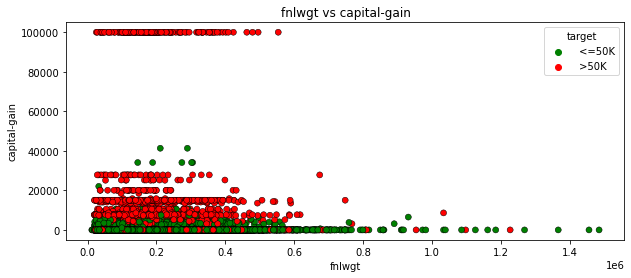

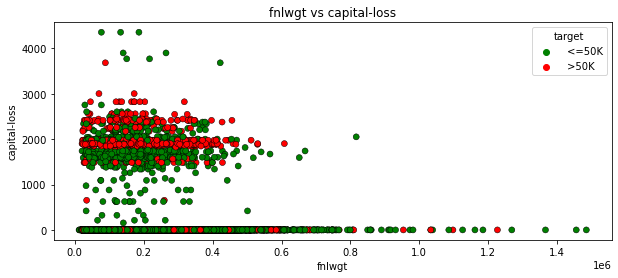

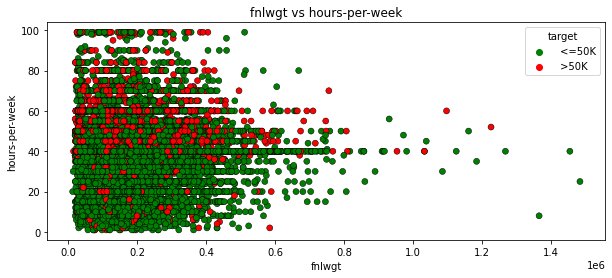

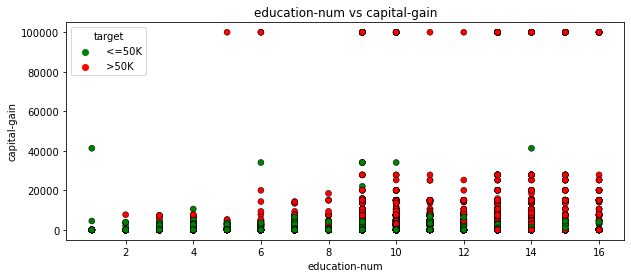

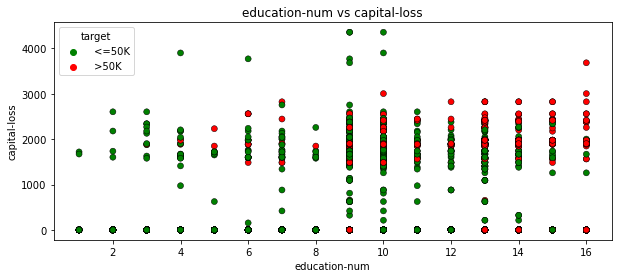

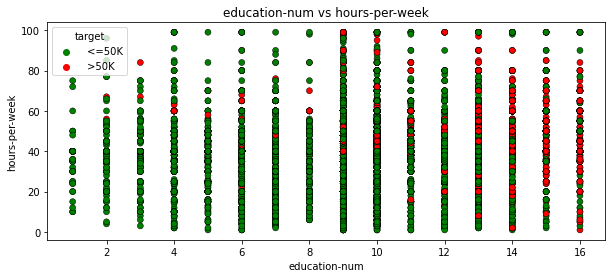

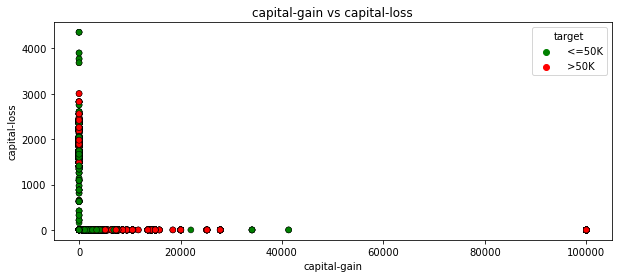

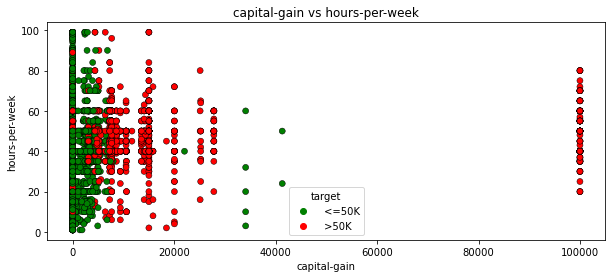

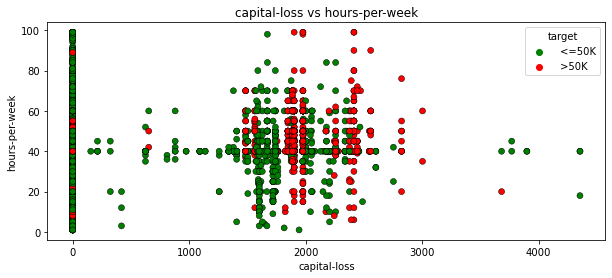

In [35]:
# now lets capture the relations between numerical columns :

def num_num_column_bivariate(df,i,j):
    palette ={' <=50K' : 'green', ' >50K' : 'red'}
    edgecolor = 'black'
    fig = plt.figure(figsize=(10,4))
    ax1 = sns.scatterplot(x = df[i], y = df[j], hue = "target",
                        data = df, palette = palette, edgecolor=edgecolor)
    plt.title(i + ' vs ' + j)
    plt.show()
    
for i in num_columns:
    for j in num_columns[num_columns.index(i):]:
        if i !=j:
            num_num_column_bivariate(df_data, i,j)

In [36]:
## more the education-num , chances of error is more,
## capital loss not related to captial-gain 
## lot of errors occured at captial-loss from 1000 to 2000 
## outliers in captial gain , hours peek -- most of  outliers resulted in more salary 
## captial gain more, target is more. ---> to be observed 
## data is provided , dont seem contain multi collinearity so now going through pair plot to see over view, 
##  and chisquare, to check relations between cat-cat. and box plots to get view of num-cat. 


### PAIR PLOT :

<Figure size 840x560 with 0 Axes>

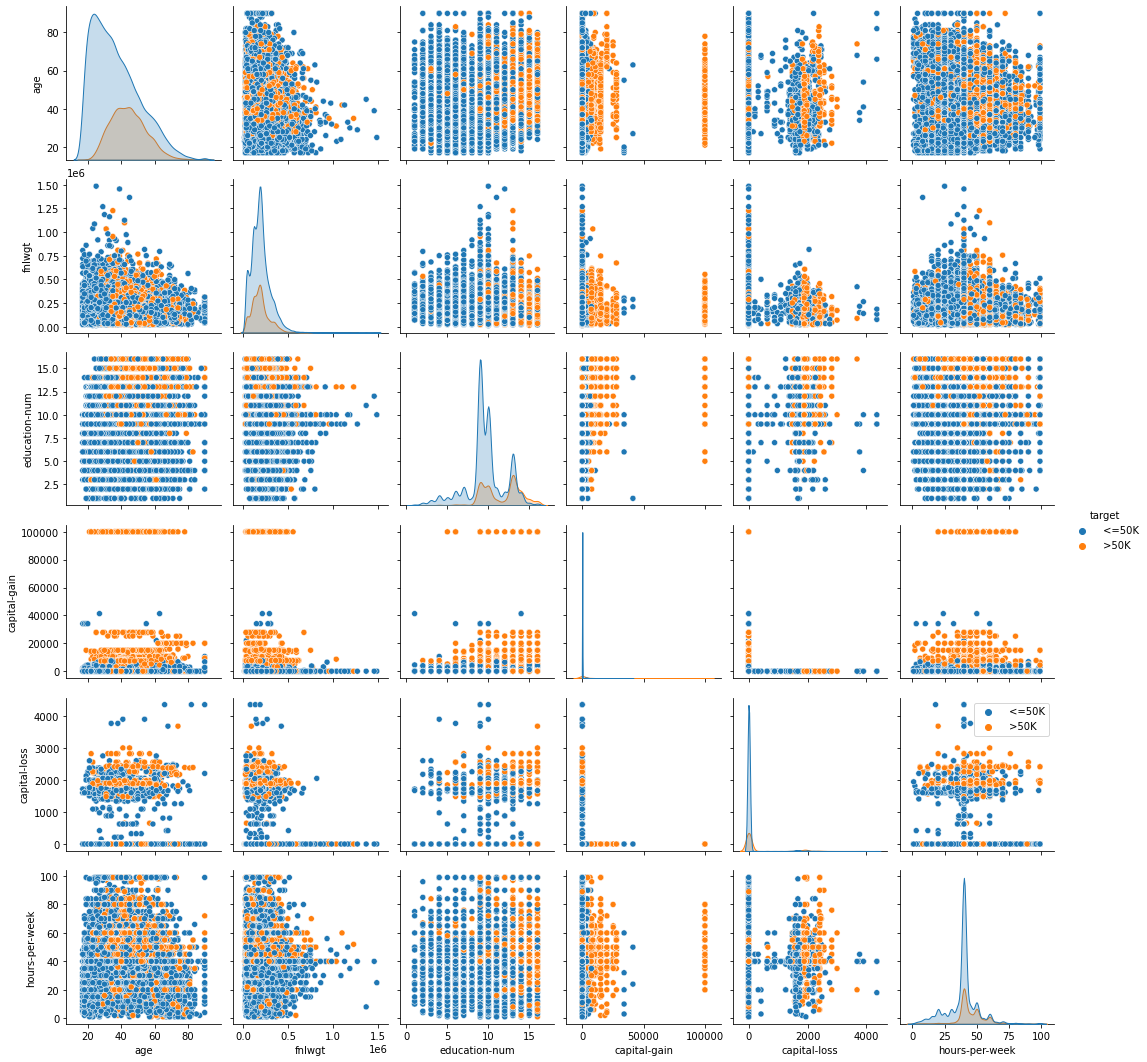

In [37]:
plt.figure(dpi = 140)
sns.pairplot(df_data,hue='target')
plt.legend(loc='best')
plt.show()

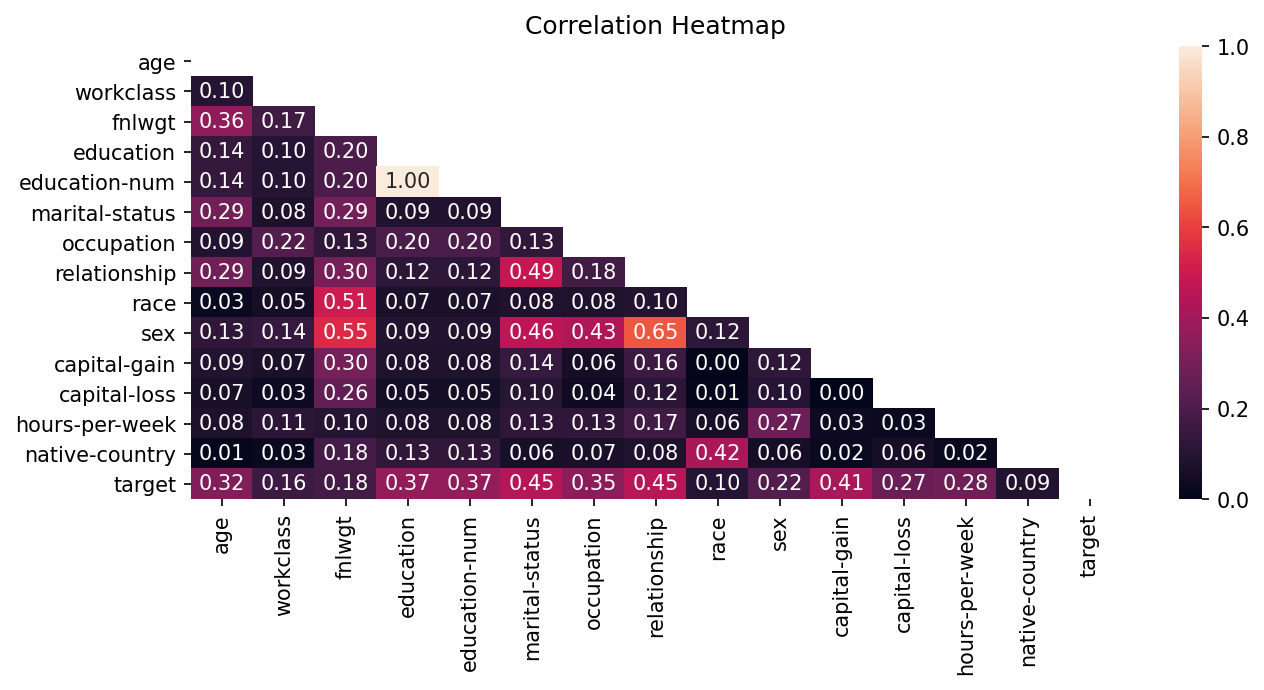

In [38]:
import itertools
import scipy.stats as ss
## THIS CONTENT IS TAKEN FROM NET, FOR MY REFERENCE, I HAVE KNOWLEGE OF CRAMERS V:
def cramers_v(matrix):
    """ calculate Cramers V statistic for categorical-categorical association.
        Using Chi2 , it help to check the relation and also get for both cat, cat and numerial also . 
    """
    chi2 = ss.chi2_contingency(matrix)[0]
    n = matrix.sum().sum()
    phi2 = chi2/n
    r,c = matrix.shape
    phi2corr = max(0, phi2 - ((c-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    ccorr = c - ((c-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (ccorr-1), (rcorr-1)))

matrix_table = np.zeros((len(df_data.columns),len(df_data.columns)))
# there's probably a nice pandas way to do this
for col1, col2 in itertools.combinations(columns, 2):
    idx1, idx2 = columns.index(col1), columns.index(col2)
    matrix_table[idx1, idx2] = cramers_v(pd.crosstab(df_data[col1], df_data[col2]) ) #creates matrix
    matrix_table[idx2, idx1] = matrix_table[idx1, idx2]
df_corr = pd.DataFrame(matrix_table, index=columns, columns=columns)
####heatmap
mask = np.triu(np.ones_like(df_corr))
fig, ax = plt.subplots(figsize=(10, 4),dpi=150)
ax = sns.heatmap(df_corr, annot=True, ax=ax,mask = mask,fmt = ".2f")
ax.set_title("Cramer V Correlation between Variables")
plt.yticks(rotation = 0)
plt.xticks(rotation = 90)
plt.title('Correlation Heatmap')
plt.show()

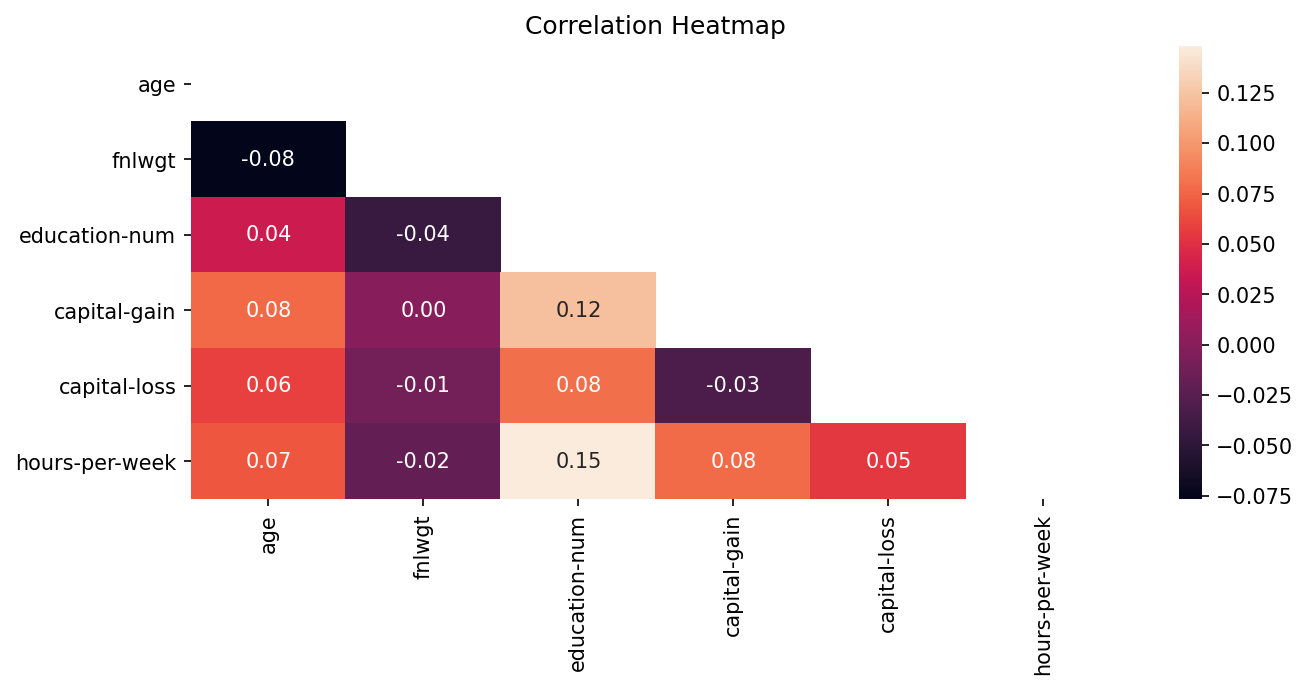

In [39]:
#Normal Correlation :
####heatmap
mask = np.triu(np.ones_like(df_data.corr()))
fig, ax = plt.subplots(figsize=(10, 4),dpi=150)
ax = sns.heatmap(df_data.corr(), annot=True, ax=ax,mask = mask,fmt = ".2f")
ax.set_title("Correlation between Variables")
plt.yticks(rotation = 0)
plt.xticks(rotation = 90)
plt.title('Correlation Heatmap')
plt.show()

In [40]:
### Relations : (sex, relationship),(race,fnlwgt),(sex,fnlwgt),(education-num, education):

### with target column : (education-num,martial-status,relation-ship,captial gain ) ## this helps us to identify important features,


KeyboardInterrupt: 

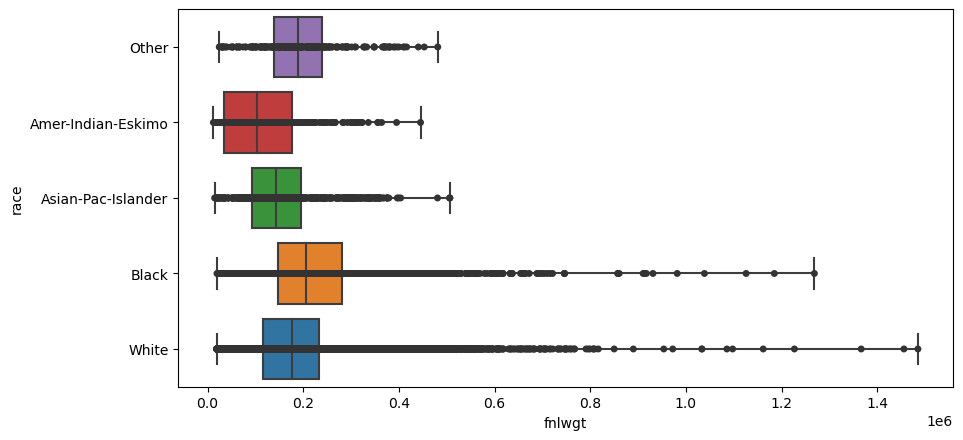

In [41]:
#sex relationship:
plt.figure(figsize=(10,5),dpi=100)
ax = sns.boxplot(x="fnlwgt", y="race", data=df_data, whis=np.inf)
ax = sns.swarmplot(x="fnlwgt", y="race", data=df_data, color=".2")

In [ ]:
 # sex, fnlwgt, race, --- 
sns.catplot(x="race", y="fnlwgt", data=df_data, hue="target", col="sex", kind="swarm",height=4, aspect=.7)

### NOW TREATING AND DOING DATA ANLAYSIS BY UTILISING THE ABOVE ANALYSIS :

##### WE HAVE SEEN MISSING VALUES 
##### WE HAVE SEEN SPREAD OF DATA MORE --> OUTLIERS
##### WE HAVE SEEN DATA IS SKEWED, CAN BE TRANSFORMED
##### WE HAVE SEEN DATA IS OUT OF RANGE WHEN COMPARED TO AGE, ---> SCALING IS NEEDED
##### BY CHISQUARE WE GOT TO KNOW THERE EXIST MULTICOLLINEARITY  BETWEEN COLUMNS -- TREAT THIS, 
##### FEATURE SELECTION IS NEEDED
##### DATA IS NOT IMBALANCED DATA, SINCE 24% 75% , BETTER NOT TO USE SMOTE TECHNIQUES , STILL BIAS AND VARIANCE COULD BE MATCHED WITH REAL TIME SCENARIOS

In [45]:
df_data.target

0         <=50K
1         <=50K
2         <=50K
3         <=50K
4         <=50K
          ...  
32556     <=50K
32557      >50K
32558     <=50K
32559     <=50K
32560      >50K
Name: target, Length: 32561, dtype: object

In [42]:
cat_columns

['workclass',
 'education',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native-country']

In [109]:
#dealing missing values :
# since we have seen missing values in categorical values, and seen for lot of salary<50, better select most frequent category-
## -with respect to same column for filter salary<50 can functional make sense, so taking those

def dealing_missing_values(df_data,df_test,test=0):

    
    #trimming the space :
    df_data[cat_columns]=df_data[cat_columns].applymap(lambda x : str(x).strip())
    
    #Checcking appereance of '?' is at same time or not :
    df_data[cat_columns]=df_data[cat_columns].replace('?',np.NaN)
    
    for i in cat_columns:
        df_data[i].fillna(df_data.loc[df_data['target']==0][i].mode()[0],inplace=True)
    if(test!=0):
        for i in cat_columns:
            df_test[i].fillna(df_data.loc[df_data['target']==0][i].mode()[0],inplace=True)
        return df_test
    return df_data


def trasnformation(df_data):
    # Data is Postive data, since we have good ammount of skew ness, we can go with box-cox method, 

    # after outliers ----
    # LOG TRANFORMATION CAN ALSO BE APPLIED. but since i have chance of boxcox -- i can transform to become normal distribution
    # since data is 0 and more than 0 we can go to log transformation 

    # from -1 to 1 skew ness i acceptable, but over to that it is more skewed --> Tranformed

    df_transform=df_data.copy()
    #columns to be transformed:
    col_to_be_transformed=df_data.agg(['skew', 'kurtosis']).T.loc[(df_data.agg(['skew', 'kurtosis']).T['skew']>1) & (df_data.agg(['skew', 'kurtosis']).T['kurtosis']>3)].index

    print(' COLUMNS BEFORE TRANSFORMED ',col_to_be_transformed)

    print(' Before Transforming ')
    df_transform[col_to_be_transformed].hist(figsize=(10,10))

    # for i in col_to_be_transformed:
    # #     df_transform[i],lambda_value = ss.boxcox(df_data[i].copy())
    # transformer = FunctionTransformer(np.log1p) or  0 values are present in data so we can neglect this. 
    # df_transform[col_to_be_transformed]=df_transform[col_to_be_transformed].applymap(lambda x: np.log(x+1))
    
    from sklearn.preprocessing import PowerTransformer as pt
    yeo= pt(method='yeo-johnson', standardize=False)

    df_transform[col_to_be_transformed]=yeo.fit_transform(df_data[col_to_be_transformed])

    print(' After Transforming ')
    df_transform[col_to_be_transformed].hist(figsize=(10,10))

    return df_transform

def outlier_by_iqr(df_data,column):    
    #calculate interquartile range 
    # IQR
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75) 
    IQR = np.int(np.abs(Q3 - Q1 ))
    # Upper bound
    upper = df[df[column] >= (Q3+3*IQR)][column]
    # Lower bound
    lower = df[df[column] <= (Q1-3*IQR)][column]
    df_data[column].apply(lambda x : x if x<upper else x)
    df_data[column].apply(lambda x : x if x>lower else x)
    return df_data[column]
    
    
    
### Final Funciton to treat the data :

def treatment_of_data(df_data,df_test=np.NaN,outlier=0,transform=0,test=0,col_transformer_derived=None):
    cat_columns=['workclass','education','marital-status','occupation','relationship','race','sex','native-country']
    num_columns=['age','fnlwgt','education-num','capital-gain','capital-loss','hours-per-week']
    
    # our motive is to look clearly on people who crossed 50 k based on census, so taking it as 1 and other as 0
    df_data.target=df_data.target.apply(lambda x : 1 if x.strip()=='>50K' else 0)
    
    #########################################
    
    print(' Treating Missing Values :   ')
    #Treating Missing Values 
    df_missed_treated=dealing_missing_values(df_data,df_test,test)
    print('Missed Values are Treated')
    
    #########################################
    if outlier!=0:
        print('Outliers treatment started')
        for i in num_columns:
            df_missed_treated[i]=outlier_by_iqr(df_missed_treated,i)
        print('Outliers are treated')
    
    #########################################
    
    if transform!=0:
        print(' Transformation Started ')
        df_missed_treated=transformation(df_missed_treated)
        print('Transformation Completed')
    
    #########################################
    #Feature Selection
    # from Crammers V ( indirectly uses chi square -- feature selection technique (statistically ) - so taking out )
    # ITS better to remove categorical because how ever we need to convert or label encode it 
    df_missed_treated.drop('education',axis=1,inplace=True)
    cat_columns.remove('education')
    #########################################
    
    ## Encoding  ##  Scaling 
    #setting the pipes for the transformation 
    categorical_pipe = Pipeline([('get_dummies',WOEEncoder(handle_unknown=0)),('scaling',StandardScaler())])
    numeric_pipe = Pipeline([('scaling',StandardScaler())])
    if test==0 :
        # set up columnTransformer
        col_transformer_derived = ColumnTransformer(
                            transformers=[
                                ('cat', categorical_pipe, cat_columns), ('num', numeric_pipe, num_columns)
                            ],
                            remainder='passthrough',
                            n_jobs=-1
                            )
        df_final=col_transformer_derived.fit_transform(df_missed_treated.drop('target',axis=1).copy(),df_missed_treated['target'].copy())
    else :
        df_final=col_transformer_derived.transform(df_missed_treated)
        print(pd.DataFrame(df_final).shape)
    
    print(df_missed_treated.columns)
    
    if test==0:
        df_final=pd.DataFrame(df_final,columns=df_missed_treated.drop('target',axis=1).columns)
        df_final['target']=df_data['target']
        return df_final,col_transformer_derived
    else:
        return pd.DataFrame(df_final,columns=df_missed_treated.columns)

In [59]:
#Multicollinearity : 
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)
dt,_ = treatment_of_data(df_data.copy(),outlier=0,transform=0,test=0)
calc_vif(dt)

 Treating Missing Values :   
Missed Values are Treated
Index(['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status',
       'occupation', 'relationship', 'race', 'sex', 'capital-gain',
       'capital-loss', 'hours-per-week', 'native-country', 'target'],
      dtype='object')


,variables,VIF
0,age,1.111968
1,workclass,4.977199
2,fnlwgt,1.408015
3,education-num,5.080226
4,marital-status,1.040886
5,occupation,1.235803
6,relationship,1.089801
7,race,1.265360
8,sex,1.032595
9,capital-gain,1.401825


In [60]:
# no more columns to be removed 

In [61]:
# important features

 Treating Missing Values :   
Missed Values are Treated
Index(['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status',
       'occupation', 'relationship', 'race', 'sex', 'capital-gain',
       'capital-loss', 'hours-per-week', 'native-country', 'target'],
      dtype='object')


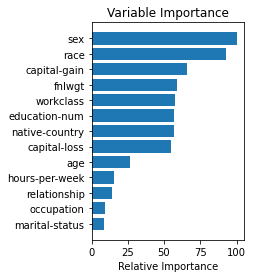

In [62]:
df,_=treatment_of_data(df_data.copy(),outlier=0,transform=0,test=0)
feature_cols = df.columns.drop('target')
target = df.target
#model = RandomForestRegressor(n_estimators=100, random_state=0)
#my_pipeline.fit(X_train, y_train)
from sklearn.ensemble import ExtraTreesClassifier
array = df.values
X = array[:,0:-1]
Y = array[:,-1]
# feature extraction
model = ExtraTreesClassifier(n_estimators=10)
model.fit(X, Y)
#print(model.feature_importances_,feature_cols)
feature_importance =model.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, df.columns[sorted_idx])#boston.feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()




### Model Selection :

In [93]:
df_train,col_transformer= treatment_of_data(df_data.copy(),outlier=0,transform=0,test=0)
# we can save col_transformer, or we can save the pickle file and utilize it when needed

 Treating Missing Values :   
Missed Values are Treated
Index(['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status',
       'occupation', 'relationship', 'race', 'sex', 'capital-gain',
       'capital-loss', 'hours-per-week', 'native-country', 'target'],
      dtype='object')


In [64]:
X_train,X_test,Y_train,Y_test=train_test_split(df_train.drop('target',axis=1),df_train['target'],test_size=0.20,random_state=10)

In [65]:
#listing the model to be done,
all_models={
#logistic regression
'logistic_regression':LogisticRegression(),

#random forest classifier
'random_forest' : RandomForestClassifier(random_state=10),

#GRADIENT BOOSTING CLASSIFIER
'gradient': GradientBoostingClassifier(),

#Knn 
'knn': KNeighborsClassifier(),

#DESICION TREE
'desicion_tree' : DecisionTreeClassifier(),

# #XGBOOST 
# import xgboost as xgb
# xgbcl = xgb.XGBClassifier()

#SVc
'svc': SVC(gamma='auto'),


#naive bayes

'guassiannb':GaussianNB()
    }



In [66]:
acc=pd.DataFrame(index=['Score'])
def cross_validation(name,model):
    acc[name]='10'
    for i in acc.index:
            acc.loc[i,name]=''
            scores = cross_validate(model, X_train, Y_train, scoring='accuracy',cv = KFold(n_splits=5))
            acc.loc[i,name]="%0.4f (+/- %0.4f)" % (scores['test_score'].mean(), scores['test_score'].std() * 2)

for i,j in all_models.items():
    cross_validation(i,j)



In [67]:
acc.T

,Score
logistic_regression,0.8491 (+/- 0.0152)
random_forest,0.8617 (+/- 0.0074)
gradient,0.8677 (+/- 0.0119)
knn,0.8360 (+/- 0.0116)
desicion_tree,0.8156 (+/- 0.0093)
svc,0.8546 (+/- 0.0123)
guassiannb,0.8310 (+/- 0.0145)


In [69]:
# Since Random Forest is best for mitigating overfitting, and being robust model . 


Metric Desicion :

Need of Census data : Indispensable for social and economic planning of the Country



Problem : 
 CHECKING PEOPLE WHETHER THEY ARE EARNING MORE THAN 50K 
 
 IF WE GET FN MORE : MORE PEOPLE EARNING MORE THAN 50 K SHOW AS < THAN 50 K ( EMPLOYEE EARNING LESS THAN STUDENT)
         Risk : Planning of country -- turns for non development of country rather turns to be people and their individual benfit planning. ( Since earning less , focus shifts on peoples benfits rather social planning , as thinking will be people are earning less, we need to do something to people first then for economic development )  (More Pessimist)
 
 IT WE GET FP MORE : MORE PEOPLE EARNING LESS 50K SHOWN AS > 50K (EMPLOYEE EARNING MORE THAN STUDENT) 
         Risk : Planning of country moves forward --> and even people are earning less, if someone trust my model and think more development can be done , and even if someone collects data and then taxes can also be increased. : (Higher Risk from people's perceptive) (Optimist )

Since both measures are relatively important, as census data objective is strictly for knowing how much country can help gov for the country growth, here objective of gov(client) is to increase the nation socially, economically, at same time it should not turn out , gov think it should put its money into poeple first and then for country .. 

Since Client is Gov, and metric needs to create strictly in plan of Development, -- Taxes comes from no where. 

SO FN is more important than FP, we need to compress FN more, So that gov can utilise real salary structure, 

Since recall = TP / (TP +FN) , as recall increases, FN decreases. I choose recall here.


Note: Since Both can be risky terms, we can go for F1 -Score. but i feel , from gov point of view -- Recall may be correct metrics

In [70]:
def create_model(clf):
    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 100)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt','log2']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(10, 1000,50)]
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4,6]
    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                  'criterion':['entropy','gini']}
    print(random_grid)

    model_randomcv=RandomizedSearchCV(estimator=clf,param_distributions=random_grid,n_iter=50,cv=3,verbose=2,
                                   random_state=100,n_jobs=-1,scoring='recall')

    ### fit the randomized model
    model_randomcv.fit(X_train,Y_train)


    return model_randomcv

In [71]:
#random forest classifier
random_forest= RandomForestClassifier(random_state=10)
model=create_model(random_forest)

{'n_estimators': [200, 218, 236, 254, 272, 290, 309, 327, 345, 363, 381, 400, 418, 436, 454, 472, 490, 509, 527, 545, 563, 581, 600, 618, 636, 654, 672, 690, 709, 727, 745, 763, 781, 800, 818, 836, 854, 872, 890, 909, 927, 945, 963, 981, 1000, 1018, 1036, 1054, 1072, 1090, 1109, 1127, 1145, 1163, 1181, 1200, 1218, 1236, 1254, 1272, 1290, 1309, 1327, 1345, 1363, 1381, 1400, 1418, 1436, 1454, 1472, 1490, 1509, 1527, 1545, 1563, 1581, 1600, 1618, 1636, 1654, 1672, 1690, 1709, 1727, 1745, 1763, 1781, 1800, 1818, 1836, 1854, 1872, 1890, 1909, 1927, 1945, 1963, 1981, 2000], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [10, 30, 50, 70, 90, 111, 131, 151, 171, 191, 212, 232, 252, 272, 292, 313, 333, 353, 373, 393, 414, 434, 454, 474, 494, 515, 535, 555, 575, 595, 616, 636, 656, 676, 696, 717, 737, 757, 777, 797, 818, 838, 858, 878, 898, 919, 939, 959, 979, 1000], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4, 6], 'criterion': ['entropy', 'gini']}
Fitting 3 folds for e

In [72]:
 #checking best parameters
print(model.best_params_)
#taking the best estimators
best_random_grid=model.best_estimator_


{'n_estimators': 1109, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 313, 'criterion': 'gini'}


In [75]:
#Training the Model with Complete data :


In [76]:
random_forest_model= RandomForestClassifier(**model.best_params_,random_state=42,n_jobs=-1,verbose=1)
random_forest_model.fit(df_train.drop('target',axis=1).copy(),df_train.target)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 1109 out of 1109 | elapsed:   10.3s finished


RandomForestClassifier(max_depth=313, max_features='log2', n_estimators=1109,
                       n_jobs=-1, random_state=42, verbose=1)

In [173]:
# Test data : 
y_true=df_test.target.apply(lambda x : 1 if x.strip()=='>50K' else 0)
df_test_treated=treatment_of_data(df_data.copy(),df_test.drop('target',axis=1).copy(),outlier=0,transform=0,test=1,col_transformer_derived=col_transformer).copy()

 Treating Missing Values :   
   age         workclass  fnlwgt  education  education-num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       marital-status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

   capital-gain  capital-loss  hours-per-week native-country  target  
0          2174             0              40  United-States       0  
1         

In [174]:
y_pred=random_forest_model.predict(df_test_treated)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done 1109 out of 1109 | elapsed:    2.4s finished


In [188]:
#printing confusion matrix
print(confusion_matrix(y_true,y_pred))
conf_matrix_grid=confusion_matrix(y_true,y_pred)
from sklearn.metrics import recall_score,roc_curve

#classification report 
print("Classification report:\n {}".format(classification_report(y_true,y_pred)))


[[13030  3251]
 [    0     0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.80      0.89     16281
           1       0.00      0.00      0.00         0

    accuracy                           0.80     16281
   macro avg       0.50      0.40      0.44     16281
weighted avg       1.00      0.80      0.89     16281



In [189]:
lr=LogisticRegression(random_state=42)
lr.fit(df_train.drop('target',axis=1).copy(),df_train.target)
y_pred=lr.predict(df_test_treated)
#printing confusion matrix
print(confusion_matrix(y_true,y_pred))
conf_matrix_grid=confusion_matrix(y_true,y_pred)
from sklearn.metrics import recall_score,roc_curve

#classification report 
print("Classification report:\n {}".format(classification_report(y_true,y_pred)))



[[13178  3103]
 [    0     0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.81      0.89     16281
           1       0.00      0.00      0.00         0

    accuracy                           0.81     16281
   macro avg       0.50      0.40      0.45     16281
weighted avg       1.00      0.81      0.89     16281



In [194]:
rf_no_hyper=RandomForestClassifier(random_state=42)
rf_no_hyper.fit(df_train.drop('target',axis=1).copy(),df_train.target)
y_pred=rf_no_hyper.predict(df_test_treated)
#printing confusion matrix
print(confusion_matrix(y_true,y_pred))
conf_matrix_grid=confusion_matrix(y_true,y_pred)
from sklearn.metrics import recall_score,roc_curve

#classification report 
print("Classification report:\n {}".format(classification_report(y_true,y_pred)))


[[13030  3251]
 [    0     0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.80      0.89     16281
           1       0.00      0.00      0.00         0

    accuracy                           0.80     16281
   macro avg       0.50      0.40      0.44     16281
weighted avg       1.00      0.80      0.89     16281



In [171]:
def dealing_missing_values(df_data,df_test,test=0):
   
    #trimming the space :
    df_data[cat_columns]=df_data[cat_columns].applymap(lambda x : str(x).strip())
    df_test[cat_columns]=df_test[cat_columns].applymap(lambda x : str(x).strip())

    #Checcking appereance of '?' is at same time or not :
    df_data.loc[:,cat_columns]=df_data[cat_columns].replace('?',np.NaN)
    df_test.loc[:,cat_columns]=df_test[cat_columns].replace('?',np.NaN)
    
    print(df_data.head())
    
    for i in cat_columns:
        df_data.loc[:,i].fillna(df_data.loc[df_data['target']==0][i].mode()[0],inplace=True)
    
    if(test!=0):
        for i in cat_columns:
            df_test[i].fillna(df_data.loc[df_data['target']==0][i].mode()[0],inplace=True)
        return df_test.copy()
    return df_data.copy()

In [168]:
### Final Funciton to treat the data :

def treatment_of_data(df_data,df_test=np.NaN,outlier=0,transform=0,test=0,col_transformer_derived=None):
    cat_columns=['workclass','education','marital-status','occupation','relationship','race','sex','native-country']
    num_columns=['age','fnlwgt','education-num','capital-gain','capital-loss','hours-per-week']
    
    # our motive is to look clearly on people who crossed 50 k based on census, so taking it as 1 and other as 0
    df_data.target=df_data.target.apply(lambda x : 1 if x.strip()=='>50K' else 0)
    
    #########################################

    print(' Treating Missing Values :   ')
    #Treating Missing Values 
    df_missed_treated=dealing_missing_values(df_data,df_test,test)
    print('Missed Values are Treated')

    
    #########################################
    if outlier!=0:
        print('Outliers treatment started')
        for i in num_columns:
            df_missed_treated[i]=outlier_by_iqr(df_missed_treated,i)
        print('Outliers are treated')
    
    #########################################
    
    if transform!=0:
        print(' Transformation Started ')
        df_missed_treated=transformation(df_missed_treated)
        print('Transformation Completed')
    
    #########################################
    #Feature Selection
    # from Crammers V ( indirectly uses chi square -- feature selection technique (statistically ) - so taking out )
    # ITS better to remove categorical because how ever we need to convert or label encode it 
    df_missed_treated.drop('education',axis=1,inplace=True)
    cat_columns.remove('education')
    
    print(df_missed_treated.head())
    #########################################
    
    ## Encoding  ##  Scaling 
    #setting the pipes for the transformation 
    categorical_pipe = Pipeline([('get_dummies',WOEEncoder(handle_unknown=0)),('scaling',StandardScaler())])
    numeric_pipe = Pipeline([('scaling',StandardScaler())])
    if test==0 :
        # set up columnTransformer
        col_transformer_derived = ColumnTransformer(
                            transformers=[
                                ('cat', categorical_pipe, cat_columns), ('num', numeric_pipe, num_columns)
                            ],
                            remainder='passthrough',
                            n_jobs=-1
                            )
        df_final=col_transformer_derived.fit_transform(df_missed_treated.drop('target',axis=1).copy(),df_missed_treated['target'].copy())
    else :
        df_final=col_transformer_derived.transform(df_missed_treated)
        
        print(pd.DataFrame(df_final,columns=df_missed_treated.columns).head())
    
    print(df_missed_treated.columns)
    
    if test==0:
        df_final=pd.DataFrame(df_final,columns=df_missed_treated.drop('target',axis=1).columns)
        df_final['target']=df_data['target']
        return df_final,col_transformer_derived
    else:
        return pd.DataFrame(df_final,columns=df_missed_treated.columns)